In [132]:
%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np

from wilson_cowan_beta2 import *

import scipy.sparse as sp
import math

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 24})

# Synchrony

In [240]:
N = 50
wcn = nazemi_jamali_network(N, random_edges=0)
θE = -1
θI = 8
wcn.excitatory_firing_rate = lambda x: relu(x - θE)
wcn.inhibitory_firing_rate = lambda x: relu(x - θI)

In [241]:
ts, Es, Is = wcn.simulate(10, Δt = 1e-3)

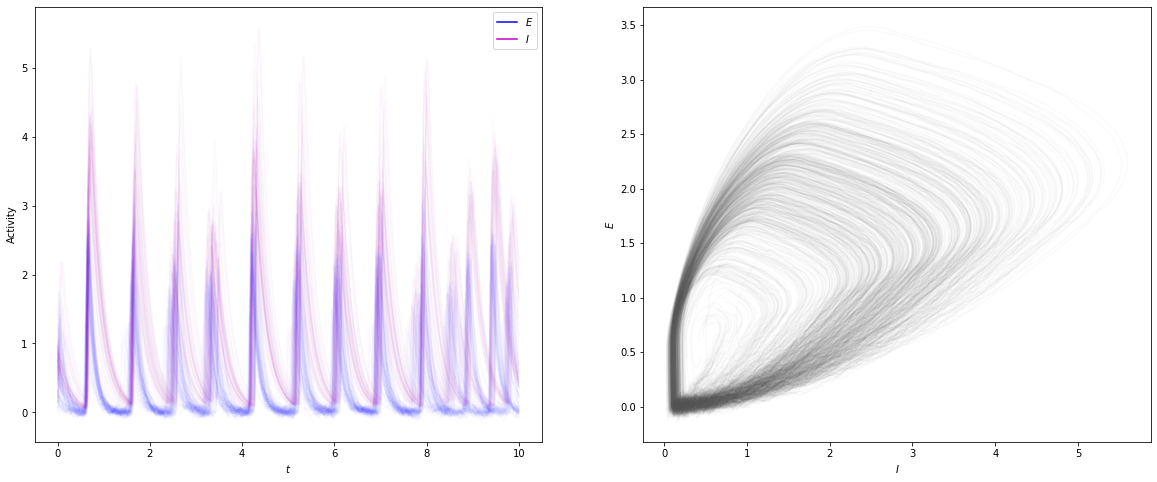

In [242]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(ts, Es, 'b-', alpha=1/N)
plt.plot([], [], 'b-', label='$E$')
plt.plot(ts, Is, 'm-', alpha=1/N)
plt.plot([], [], 'm-', label='$I$')
plt.xlabel('$t$')
plt.ylabel('Activity')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(Is, Es, 'k', alpha=1/N)
plt.xlabel('$I$')
plt.ylabel('$E$')

plt.show()

In [243]:
angles = np.linspace(0, 2*np.pi, N, endpoint=False)
xs = np.cos(angles)
ys = np.sin(angles)

fig, ax = plt.subplots(1, 1, figsize=(12,8))
plt.gca().set_aspect('equal', adjustable='box')
ax.set_facecolor('black')

# plot edges
for edge in [ (a, b) for a, b in product(range(N), range(N)) if wcn.EE_mat[a, b]!=0]:
    plt.plot(np.cos([angles[node] for node in edge]), np.sin([angles[node] for node in edge]), 'w-', zorder=0, alpha=0.5)
# end plot edges
size = 200
shrink_factor = 1.1
scatter_plot_excitatory = ax.scatter(xs, ys, s=size, c=Es[0], vmin=np.min(Es), vmax=np.max(Es), cmap='Blues_r')
scatter_plot_inhibibory = ax.scatter(xs*shrink_factor, ys*shrink_factor, s=size, c=Is[0], vmin=np.min(Is), vmax=np.max(Is), cmap='Reds_r')

def animate(i):
    print(f'step {i}/{len(ts)}', end='\r')
    scatter_plot_excitatory.set_array(Es[i])
    scatter_plot_inhibibory.set_array(Is[i])
    return scatter_plot_excitatory,


# Init only required for blitting to give a clean slate.
def init():
    scatter_plot_excitatory.set_array(Es[0])
    scatter_plot_inhibibory.set_array(Is[0])
    return scatter_plot_excitatory,

anim = animation.FuncAnimation(fig, animate, np.arange(frame_start,frame_stop,frame_stride), init_func=init,
                              interval=1/24*1000, blit=True)

# anim.save('PE_pulse.mp4', writer='imagemagick', fps=24)

plt.close()
HTML(anim.to_html5_video())

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '864x576', '-pix_fmt', 'rgba', '-r', '24.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpbh743m8i/temp.m4v']' returned non-zero exit status 255.

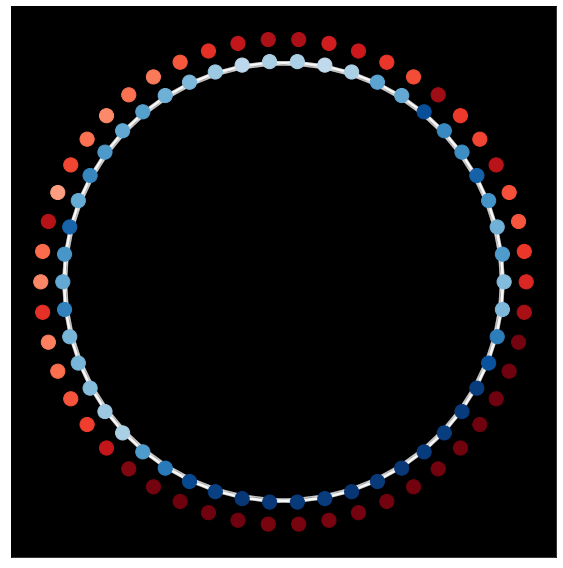

In [248]:
frame_start = len(ts)//2
frame_stop = 3*len(ts)//4
frame_stride = 30


angles = np.linspace(0, 2*np.pi, N, endpoint=False)
xs = np.cos(angles)
ys = np.sin(angles)

fig, ax = plt.subplots(1, 1, figsize=(12,8))
plt.gca().set_aspect('equal', adjustable='box')
ax.set_facecolor('black')
ax.set_xticks([])
ax.set_yticks([])

time_index = 6950

# plot edges
for edge in [ (a, b) for a, b in product(range(N), range(N)) if wcn.EE_mat[a, b]!=0]:
    plt.plot(np.cos([angles[node] for node in edge]), np.sin([angles[node] for node in edge]), 'w-', zorder=0, alpha=0.5)
# end plot edges
size = 200
shrink_factor = 1.1
scatter_plot_excitatory = ax.scatter(xs, ys, s=size, c=Es[time_index], vmin=np.min(Es), vmax=np.max(Es), cmap='Blues_r')
scatter_plot_inhibibory = ax.scatter(xs*shrink_factor, ys*shrink_factor, s=size, c=Is[time_index], vmin=np.min(Is), vmax=np.max(Is), cmap='Reds_r')


plt.tight_layout()

# plt.savefig('images/proposal_ring_pulse.png')

plt.show()

# Perc

In [227]:
def node_to_grid(a, n):
    return a%n, a//n

def grid_to_node(x, y, n):
    return x + y*n

In [228]:
n = 10
N = n**2

In [229]:
coupling_weight=.8

coupling_edges = []
for node in range(N):
    x, y = node_to_grid(node, n)
    if x < n-1:
        coupling_edges.append((node, grid_to_node(x+1,y,n), coupling_weight))
    if y < n-1:
        coupling_edges.append((node, grid_to_node(x,y+1,n), coupling_weight))
    
    
coupling_edges = randomize_edges(N, coupling_edges, 5)

In [230]:
def perc_network(n, coupling_weight=.8, neighbor_radius=3, random_edges = 0):
    '''
    Networks from Perc (2005) - Chaos Solitons and Fractals.
    '''
    N = n**2
    
    EE_weight = 8
    II_weight = 4
    EI_weight = 16
    IE_weight = 8

    # standard Wilson-Cowan connections
    EE_edges = [(a, a, EE_weight) for a in range(N)]
    II_edges = [(a, a, II_weight) for a in range(N)]
    EI_edges = [(a, a, EI_weight) for a in range(N)]
    IE_edges = [(a, a, IE_weight) for a in range(N)]

    # grid connections
    coupling_edges = []
    for node in range(N):
        x, y = node_to_grid(node, n)
        if x < n-1:
            coupling_edges.append((node, grid_to_node(x+1,y,n), coupling_weight))
        if y < n-1:
            coupling_edges.append((node, grid_to_node(x,y+1,n), coupling_weight))

    coupling_edges = randomize_edges(N, coupling_edges, random_edges)

    EE_edges = EE_edges + coupling_edges
    
    matrix_type = 'dense'
    if N > 100:
        matrix_type = 'csr'

    EE_mat = edges_to_adjacency_matrix(N, EE_edges, symmetric=True, matrix_type=matrix_type)
    II_mat = edges_to_adjacency_matrix(N, II_edges, symmetric=True, matrix_type=matrix_type)
    EI_mat = edges_to_adjacency_matrix(N, EI_edges, symmetric=True, matrix_type=matrix_type)
    IE_mat = edges_to_adjacency_matrix(N, IE_edges, symmetric=True, matrix_type=matrix_type)

    wcn = Wilson_Cowan_Network(EE_mat, EI_mat, IE_mat, II_mat)

    aE = 0.8
    θE = 2
    wcn.excitatory_firing_rate = lambda x: sigmoid(aE*(x - θE))
    aI = 0.8
    θI = 8
    wcn.inhibitory_firing_rate = lambda x: sigmoid(aI*(x - θI))

    wcn.E0 = np.random.random(N)
    wcn.I0 = np.random.random(N)
    
    return wcn

In [231]:
wcn = perc_network(n, coupling_weight=.8, neighbor_radius=3, random_edges = 0)
θE = -1
θI = 8
wcn.excitatory_firing_rate = lambda x: relu(x - θE)
wcn.inhibitory_firing_rate = lambda x: relu(x - θI)

In [232]:
ts, Es, Is = wcn.simulate(10, Δt = 1e-3)

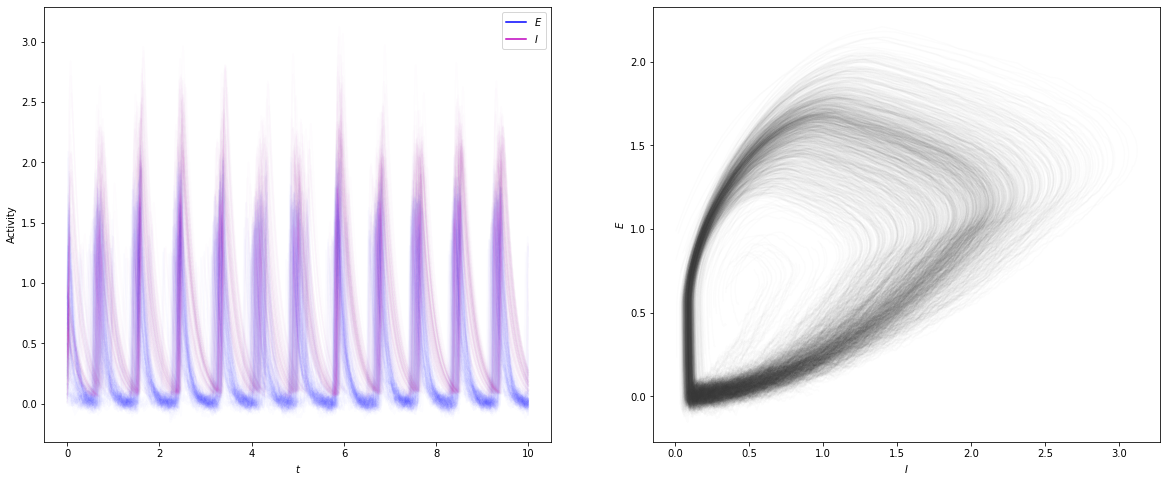

In [233]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(ts, Es, 'b-', alpha=1/N)
plt.plot([], [], 'b-', label='$E$')
plt.plot(ts, Is, 'm-', alpha=1/N)
plt.plot([], [], 'm-', label='$I$')
plt.xlabel('$t$')
plt.ylabel('Activity')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(Is, Es, 'k', alpha=1/N)
plt.xlabel('$I$')
plt.ylabel('$E$')

plt.show()

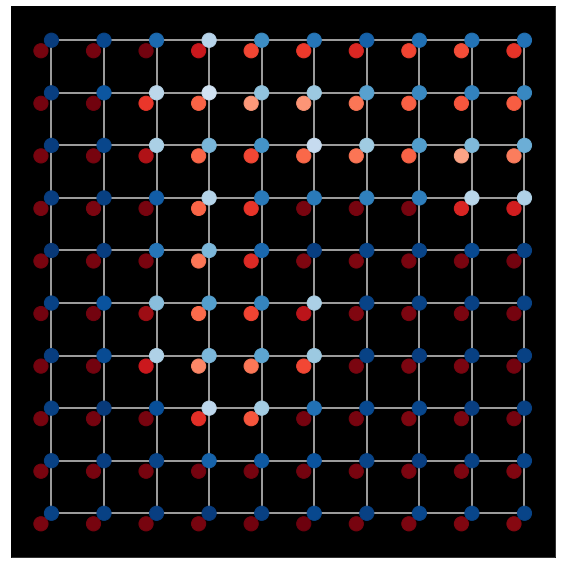

In [239]:
X, Y = np.meshgrid(range(n), range(n))

X = X.flatten()
Y = Y.flatten()

fig, ax = plt.subplots(1, 1, figsize=(12,8))
plt.gca().set_aspect('equal', adjustable='box')
ax.set_facecolor('black')
ax.set_xticks([])
ax.set_yticks([])

time_index = 6700

# plot edges
for edge in [ (a, b) for a, b in product(range(N), range(N)) if wcn.EE_mat[a, b]!=0]:
    plt.plot([X[node] for node in edge], [Y[node] for node in edge], 'w-', zorder=0, alpha=0.5)
# end plot edges
size = 200
shift = .2
scatter_plot_inhibibory = ax.scatter(X-shift, Y-shift, s=size, c=Is[time_index], vmin=np.min(Is), vmax=np.max(Is), cmap='Reds_r')
scatter_plot_excitatory = ax.scatter(X, Y, s=size, c=Es[time_index], vmin=np.min(Es), vmax=np.max(Es), cmap='Blues_r')


plt.tight_layout()

plt.savefig('images/proposal_grid_pulse.png')

plt.show()

In [235]:
X, Y = np.meshgrid(range(n), range(n))

X = X.flatten()
Y = Y.flatten()

frame_start = 0#len(ts)//2
frame_stop = len(ts)#//10#3*len(ts)//4
frame_stride = 20

fig, ax = plt.subplots(1, 1, figsize=(12,8))
plt.gca().set_aspect('equal', adjustable='box')
ax.set_facecolor('black')

# plot edges
for edge in [ (a, b) for a, b in product(range(N), range(N)) if wcn.EE_mat[a, b]!=0]:
    plt.plot([X[node] for node in edge], [Y[node] for node in edge], 'w-', zorder=0, alpha=0.5)
# end plot edges
size = 200
shift = .2
scatter_plot_inhibibory = ax.scatter(X-shift, Y-shift, s=size, c=Is[0], vmin=np.min(Is), vmax=np.max(Is), cmap='Reds_r')
scatter_plot_excitatory = ax.scatter(X, Y, s=size, c=Es[0], vmin=np.min(Es), vmax=np.max(Es), cmap='Blues_r')


def animate(i):
    print(f'step {i}/{len(ts)}', end='\r')
    scatter_plot_excitatory.set_array(Es[i])
    scatter_plot_inhibibory.set_array(Is[i])
    return scatter_plot_excitatory,


# Init only required for blitting to give a clean slate.
def init():
    scatter_plot_excitatory.set_array(Es[0])
    scatter_plot_inhibibory.set_array(Is[0])
    return scatter_plot_excitatory,

anim = animation.FuncAnimation(fig, animate, np.arange(frame_start,frame_stop,frame_stride), init_func=init,
                              interval=1/24*1000, blit=True)

# anim.save('PE_pulse.mp4', writer='imagemagick', fps=24)

plt.close()
HTML(anim.to_html5_video())

# Hexagons are the Bestagons

In [123]:
def dist_squared(point1, point2):
    return sum((x-y)**2 for x, y in zip(point1, point2))

In [126]:
dist_squared((0,0), (2, 2))

8

In [167]:
hex_radius = 3
coupling_weight = 0.8

N = 1 + 3*hex_radius + 3*hex_radius**2

x_locations = [0]
y_locations = [0]
w = np.exp(np.pi/3*1j)

for r in range(1, hex_radius+1):
    new_points = np.arange(r)*w**2 + r
    for power in range(6):
        x_locations += list(np.real(new_points*w**power))
        y_locations += list(np.imag(new_points*w**power))
    


coupling_edges = [(a, b, coupling_weight) 
         for a, point1 in enumerate(zip(x_locations, y_locations))
         for b, point2 in enumerate(zip(x_locations, y_locations))
         if a!=b and dist_squared(point1, point2)<1.1]

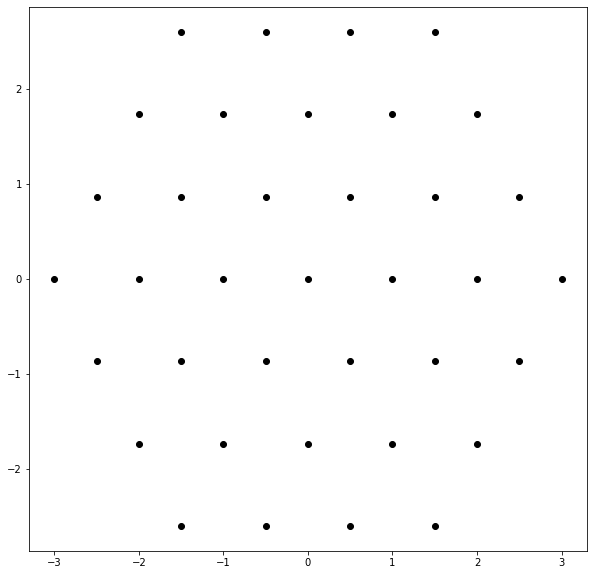

In [168]:
plt.figure(figsize=(10,10))
plt.plot(x_locations, y_locations, 'ko')

In [174]:

EE_weight = 8
II_weight = 4
EI_weight = 16
IE_weight = 8

# standard Wilson-Cowan connections
EE_edges = [(a, a, EE_weight) for a in range(N)]
II_edges = [(a, a, II_weight) for a in range(N)]
EI_edges = [(a, a, EI_weight) for a in range(N)]
IE_edges = [(a, a, IE_weight) for a in range(N)]

# ring connections
# coupling_edges = []
# for node in range(N):
#     x, y = node_to_grid(node, n)
#     if x < n-1:
#         coupling_edges.append((node, grid_to_node(x+1,y,n), coupling_weight))
#     if y < n-1:
#         coupling_edges.append((node, grid_to_node(x,y+1,n), coupling_weight))

# coupling_edges = randomize_edges(N, coupling_edges, random_edges)

EE_edges = EE_edges + coupling_edges

matrix_type = 'dense'
if N > 100:
    matrix_type = 'csr'

EE_mat = edges_to_adjacency_matrix(N, EE_edges, symmetric=True, matrix_type=matrix_type)
II_mat = edges_to_adjacency_matrix(N, II_edges, symmetric=True, matrix_type=matrix_type)
EI_mat = edges_to_adjacency_matrix(N, EI_edges, symmetric=True, matrix_type=matrix_type)
IE_mat = edges_to_adjacency_matrix(N, IE_edges, symmetric=True, matrix_type=matrix_type)

wcn = Wilson_Cowan_Network(EE_mat, EI_mat, IE_mat, II_mat)

aE = 0.8
θE = 2
wcn.excitatory_firing_rate = lambda x: sigmoid(aE*(x - θE))
aI = 0.8
θI = 8
wcn.inhibitory_firing_rate = lambda x: sigmoid(aI*(x - θI))

wcn.E0 = np.random.random(N)
wcn.I0 = np.random.random(N)

θE = -1
θI = 8
wcn.excitatory_firing_rate = lambda x: relu(x - θE)
wcn.inhibitory_firing_rate = lambda x: relu(x - θI)

In [175]:
ts, Es, Is = wcn.simulate(10, Δt = 1e-3)

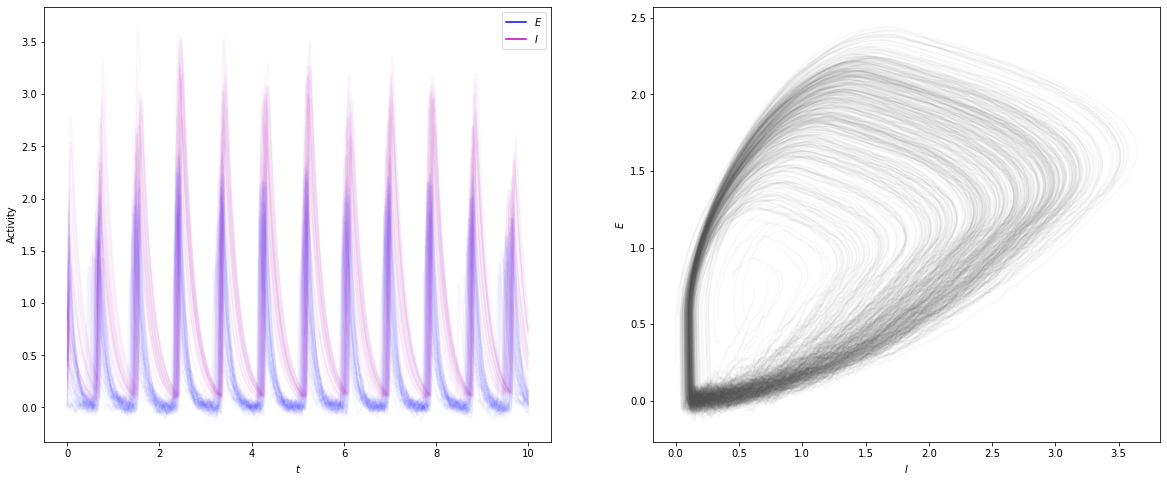

In [176]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(ts, Es, 'b-', alpha=1/N)
plt.plot([], [], 'b-', label='$E$')
plt.plot(ts, Is, 'm-', alpha=1/N)
plt.plot([], [], 'm-', label='$I$')
plt.xlabel('$t$')
plt.ylabel('Activity')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(Is, Es, 'k', alpha=1/N)
plt.xlabel('$I$')
plt.ylabel('$E$')

plt.show()

In [182]:
X = np.array(x_locations) #+ np.random.randn(N)*.05
Y = np.array(y_locations) #+ np.random.randn(N)*.05

frame_start = 0#len(ts)//2
frame_stop = len(ts)#//10#3*len(ts)//4
frame_stride = 10

fig, ax = plt.subplots(1, 1, figsize=(12,8))
plt.gca().set_aspect('equal', adjustable='box')
ax.set_facecolor('black')

# plot edges
for edge in [ (a, b) for a, b in product(range(N), range(N)) if wcn.EE_mat[a, b]!=0]:
    plt.plot([X[node] for node in edge], [Y[node] for node in edge], 'w-', zorder=0, alpha=0.5)
# end plot edges
size = 200
shift = .2
scatter_plot_inhibibory = ax.scatter(X-shift, Y-shift, s=size, c=Is[0], vmin=np.min(Is), vmax=np.max(Is), cmap='Reds_r')
scatter_plot_excitatory = ax.scatter(X, Y, s=size, c=Es[0], vmin=np.min(Es), vmax=np.max(Es), cmap='Blues_r')


def animate(i):
    print(f'step {i}/{len(ts)}', end='\r')
    scatter_plot_excitatory.set_array(Es[i])
    scatter_plot_inhibibory.set_array(Is[i])
    return scatter_plot_excitatory,


# Init only required for blitting to give a clean slate.
def init():
    scatter_plot_excitatory.set_array(Es[0])
    scatter_plot_inhibibory.set_array(Is[0])
    return scatter_plot_excitatory,

anim = animation.FuncAnimation(fig, animate, np.arange(frame_start,frame_stop,frame_stride), init_func=init,
                              interval=1/24*1000, blit=True)

# anim.save('PE_pulse.mp4', writer='imagemagick', fps=24)

plt.close()
HTML(anim.to_html5_video())

In [145]:
X[0]

0.0

In [146]:
Y[0]

0.0

In [147]:
X[1]

1.0

In [148]:
Y[1]

0.0

In [149]:
X[2], Y[2]

(0.5000000000000001, 0.8660254037844386)

In [166]:
i, j = 2, 6
dist_squared((X[i], Y[i]), (X[j], Y[j]))

3.0000000000000013

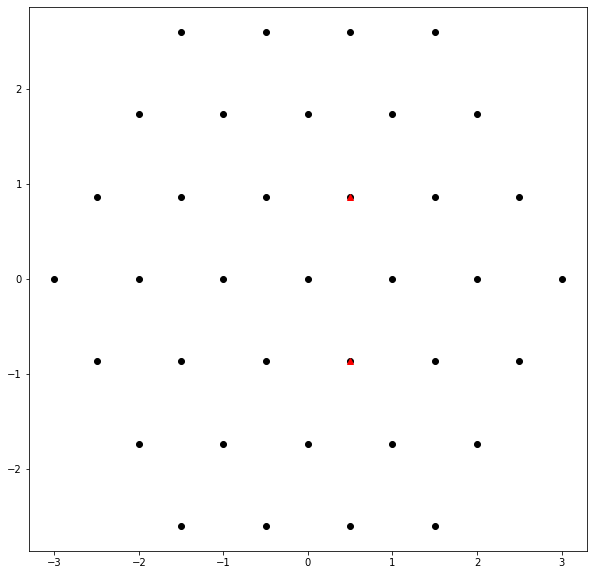

In [165]:
plt.figure(figsize=(10,10))
for i in range(N):
    plt.plot(X[i], Y[i], 'ko')
    
for i in [2, 6]:
    plt.plot(X[i], Y[i], 'r^')
